In [735]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
#from scipy.fftpack import fft
from numpy.fft import fftshift,fft
from scipy.linalg import toeplitz

### Question 1
### (a)
From the lecture notes, we know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, for each element in f we first calculate the transfer functions $G_{\phi}(f[i])$ and $G_{\theta}(f[i])$ and then we determine the sdf evaluated at $f[i]$.

In [736]:
def S_ARMA(f, phis, thetas, sigma2):
    """Input: 
    f: list of frequences at which it should be evaluated (must be in the interval [1/2, 1/2))
    phis: the list [phi_{1,p},..., phi_{p,p}]
    thetas: the list [theta_{1,q},..., theta_{q,q}]
    sigma2: a scalar for the variance of the white noise
    Output:
    S: theoretical spectral density function for a ARMA(p,q) process evaluated for each element in f."""

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    #S = [0 for i in range(len(f))]
    S = np.zeros(len(f))
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):            
        # initialize the two sums
        G_theta = 1
        G_phi = 1

        # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
        for m in range(p):
            G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
        
        # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
        for n in range(q):
            G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

        # update the ith element of S
        S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

### (b)
We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2}, \quad t>2.
\end{equation*}

In [737]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """Input:
    phis: the list [phi_{1,2}, phi_{2,2}]
    thetas: the list [theta_{1,2}, theta_{2,2}]
    sigma2: a scalar for the variance of the white noise
    N: length of simulated process
    Output: 
    Time series of length N simulated by the ARMA(2,2) process."""
    
    # initialize list recording the values of the stochastic process
    X = [0,0]

    # create list with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = np.random.normal(0,np.sqrt(sigma2), N+100)

    # recursively append the values Xt
    for i in range(2,N+100):
        X.append(phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2])
    
    # return an array with only the N values after the first 100
    return np.array(X[100:])

### (c)
The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f_k t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
\sum_{t = 0}^{N-1} X[t] e^{-i2\pi f_k (t+1)} = y[k]e^{-i 2\pi f_k},
\end{equation*}
i.e., after obtaining the $y[k]$ using the fft method, we need to multiply each element by $e^{-i 2\pi f_k}$. Our estimate of the sdf is then
\begin{equation*}
S[k] = \frac{1}{N} \big| y[k]e^{-i 2\pi f_k} \big|^2 = \frac{1}{N} \big| fft(X) e^{-i 2\pi f_k} \big|^2
\end{equation*}

We have obtained our estimate for the sdf for the Fourier frequencies $f_k$ which range from $0$ to $(N-1)/N$, however, in the lectures notes we define the periodogram over $[-1/2, 1/2)$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by using $fftshift$, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2)$.

In [738]:
def periodogram(X):
    """Input:
    X: numpy array of the time series
    Output:
    The periodogram at the Fourier frequencies for X."""
    
    N = len(X)

    # Fourier frequencies
    f_k = np.arange(0,N)/N
    
    return abs(fft(X)*(np.e**(-1j*2*np.pi*f_k)))**2/N

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper. We use the taper from the lecture notes (with slight adaptation since python counts from 0).

We want to calculate 
\begin{equation*}
\sum_{t = 1}^N h_tX_te^{i2\pi f t} \quad \text{or since python counts from 0} \quad \sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)}
\end{equation*}
Once again, since the $fft$ algorithm computes
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} h[n]X[n] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
So we need to multiply by $e^{-i2 \pi f_k}$:
\begin{equation*}
\sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)} = y[k] e^{-i2 \pi f_k}
\end{equation*}
Now we can compute the direct spectral estimator
\begin{equation*}
S[k] = \big| y[k] e^{-i2 \pi f_k} \big|^2 = \big| fft(h X) e^{-i2 \pi f_k} \big|^2
\end{equation*}
Once again, we use the $fftshift$ function, since the domain is $[-1/2, 1/2)$ instead of $[0,1)$.

In [739]:
def direct(X,p):
    """
    Input:
    X: time series
    p: variable for cosine taper
    Output:
    Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X."""
    
    N = len(X)

    # create the three intervals for the taper
    interval = np.arange(0,N)
    interval1 = interval[0:int(np.floor(p*(N))/2)]
    interval2 = interval[int(np.floor(p*(N))/2): N - int(np.floor(p*N)/2)]
    interval3 = interval[N - int(np.floor(p*N)/2): ]
    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(p*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(p*N)+1)))
    h = np.concatenate((h1, h2, h3))
    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(sum(h**2))

    # Fourier frequencies
    f_k = interval/N

    return abs(fft(h*X)*(np.exp(-1j*2*np.pi*f_k)))**2

### (d)

#### A.
We have that $r = 0.8$ and $f' = 12/128$. Using results from the lecture notes (page 51), we have that
\begin{equation*}
\phi_{1,2} = 2r \cos (2 \pi f') \quad \phi_{2,2} = -r^2.
\end{equation*}

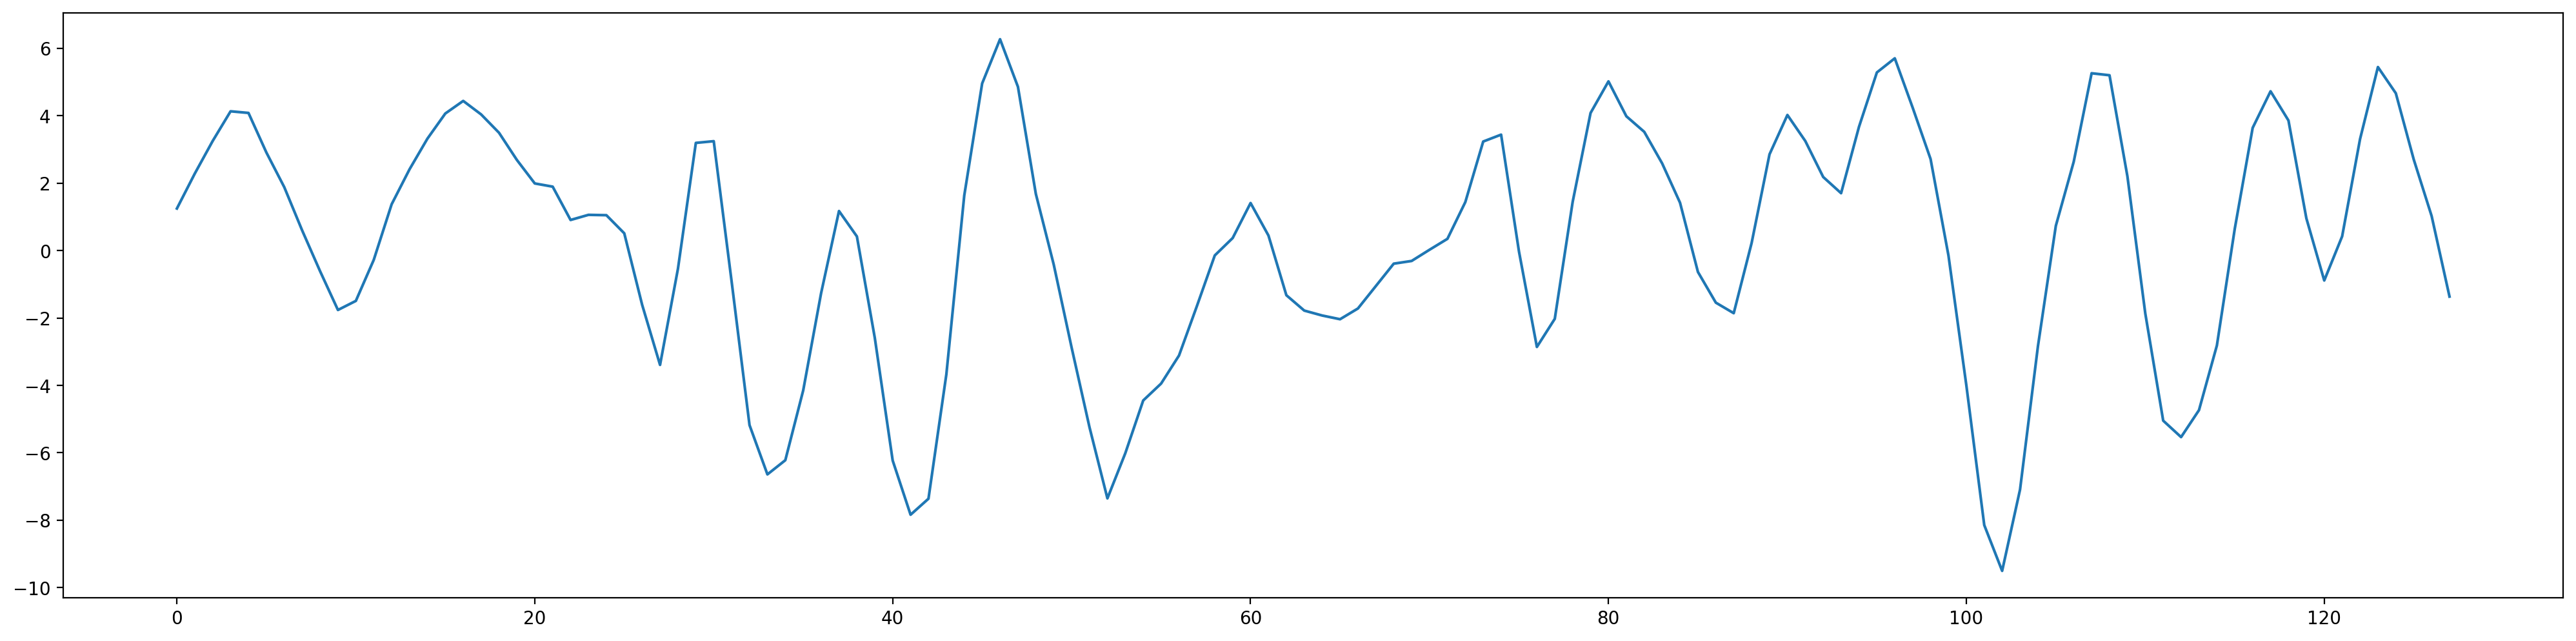

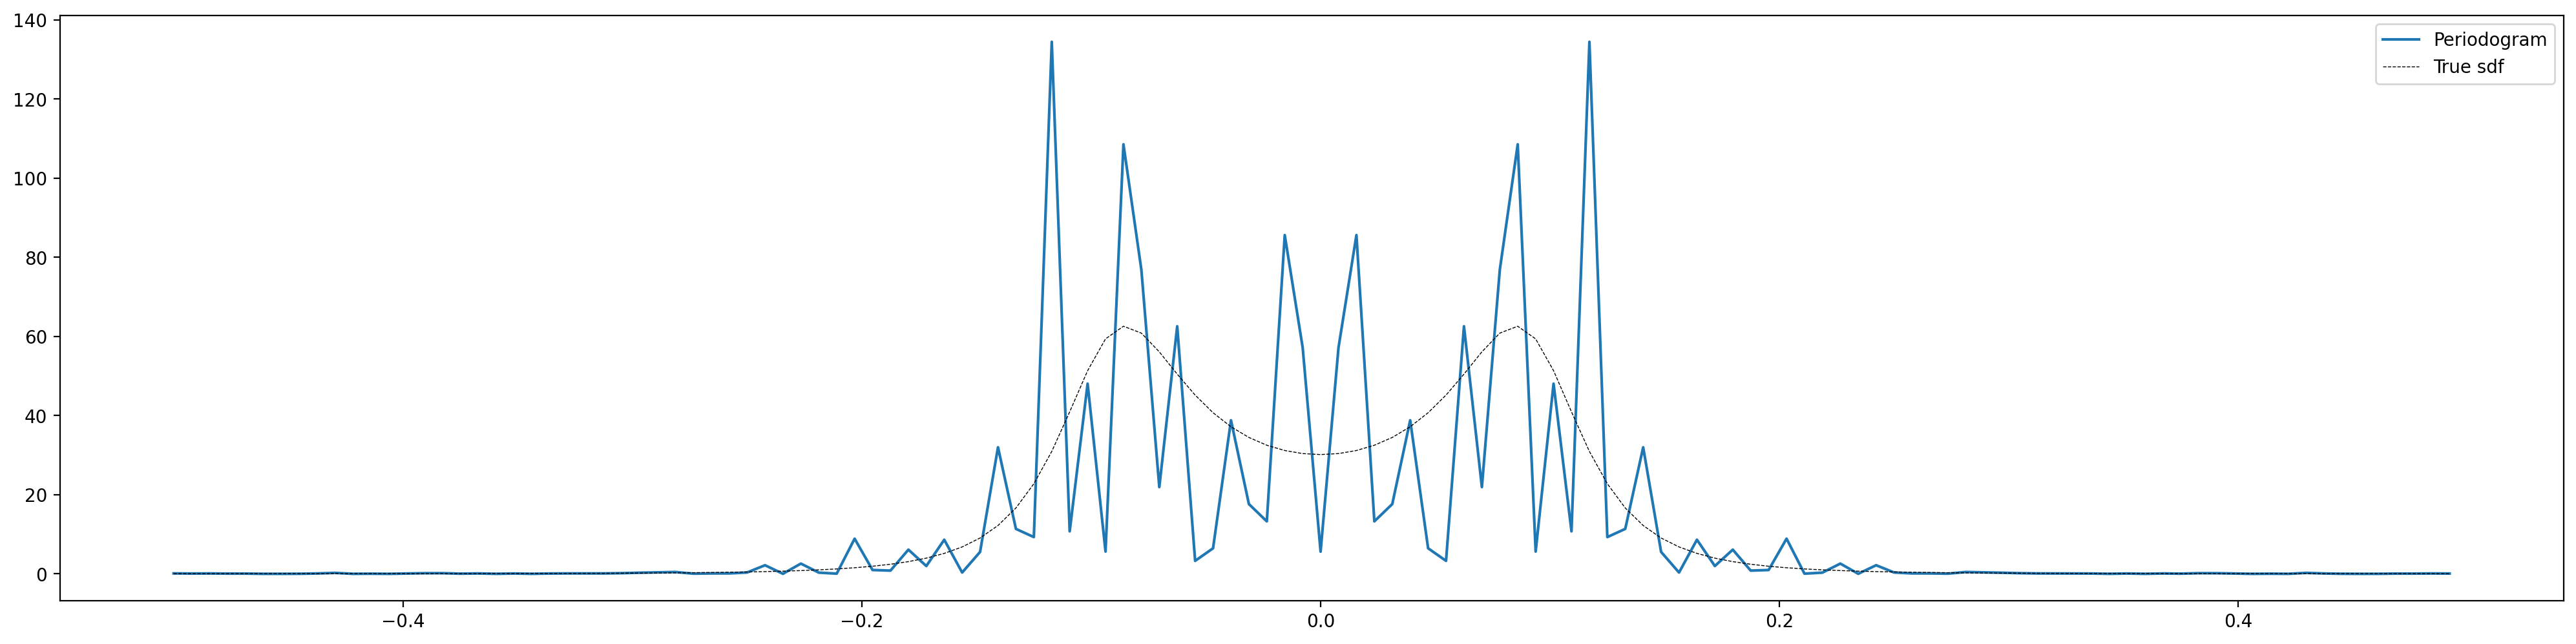

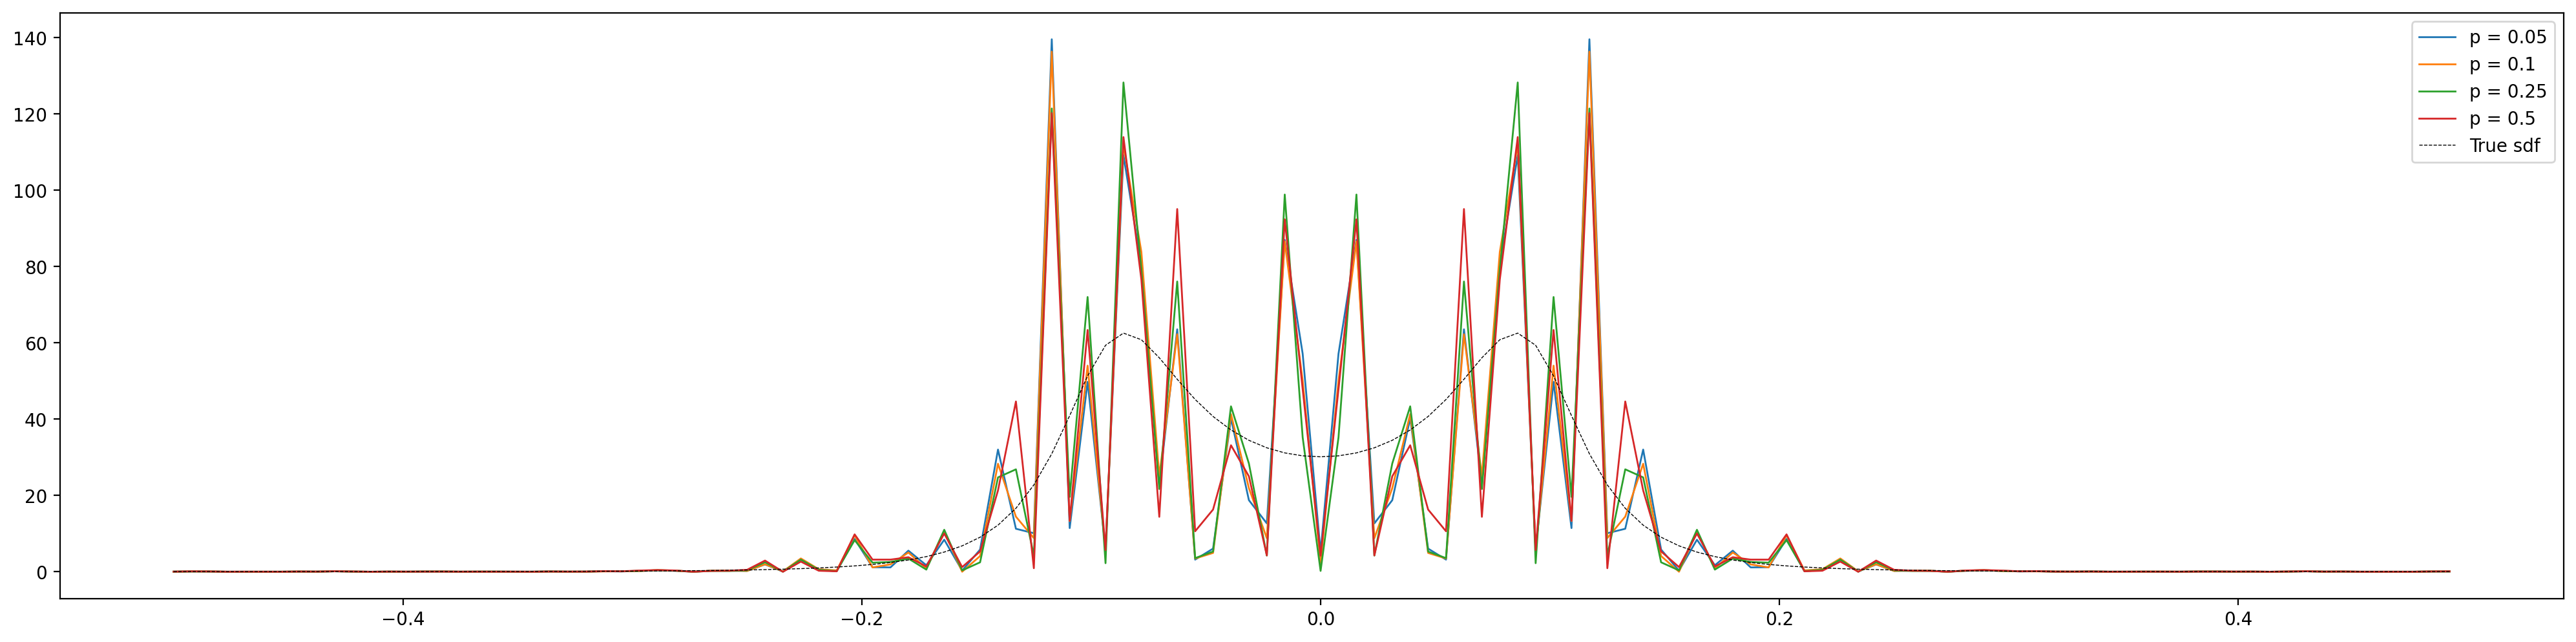

In [796]:
r = 0.8
phi_1 = 2*r*np.cos(2*np.pi*12/128)
phi_2 = -r**2
X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)
plt.figure(figsize=(25, 6), dpi = 200)
plt.plot(X)
plt.show()

# Fourier frequencies
freq = t = np.arange(-64, 64)/128

# periodogram
plt.figure(figsize=(25, 6), dpi = 200)
plt.plot(freq, fftshift(periodogram(X)), label = "Periodogram")
plt.plot(freq, S_ARMA(freq, [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1), "k--", linewidth = 0.5, label = "True sdf")  # true sdf
plt.legend()
plt.show()

# direct
plt.figure(figsize=(25, 6), dpi = 200)
for p in [0.05, 0.1, 0.25, 0.5]:
    plt.plot(freq, fftshift(direct(X, p)), linewidth = 1,label = f"p = {p}")
plt.plot(freq, S_ARMA(freq, [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1), "k--", linewidth = 0.5, label = "True sdf")  # true sdf
plt.legend()
plt.show()

In [774]:
from operator import itemgetter

r = 0.8
phi_1 = 2*r*np.cos(2*np.pi*12/128)
phi_2 = -r**2

periodogram_frequencies = []
direct_frequencies = []
for i in range(10000):
    X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)
    periodogram_frequencies.append(itemgetter(12,32,60)(periodogram(X)))
    for p in [0.05, 0.1, 0.25, 0.5]:
        direct_frequencies.append(itemgetter(12,32,60)(direct(X, p)))

In [793]:
for i in range(3):
    s = 0
    for j in range(10000):
        s += periodogram_frequencies[j][i]
    print(s/10000)

for i in range(3):
    s = 0
    for j in range(10000):
        s += direct_frequencies[j][i]
    print(s/10000)

57.26576961390857
0.6142633911272601
0.1067134645652232
57.82168526531828
0.47952302754791054
0.05729257101486454


In [794]:
for f in [12/128, 32/128, 60/128]:
    print(S_ARMA([f], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1))

[59.37582589]
[0.46856044]
[0.05584653]


In [797]:
for r in np.arange(81,100)/100:
    phi1 = 2*r*np.cos(2*np.pi*12/128)
    phi2 =  -r**2
    periodogram_frequencies = []
    direct_frequencies = []
    for i in range(10000):
        X = ARMA22_sim([phi1, phi2], [-0.5,-0.2], sigma2=1, N=128)
        periodogram_frequencies.append(itemgetter(12,32,60)(periodogram(X)))
        for p in [0.05, 0.1, 0.25, 0.5]:
            direct_frequencies.append(itemgetter(12,32,60)(direct(X, p)))

## Question 2
### (a)

In [744]:
from numpy import genfromtxt
data = list(genfromtxt('88.csv', delimiter=','))

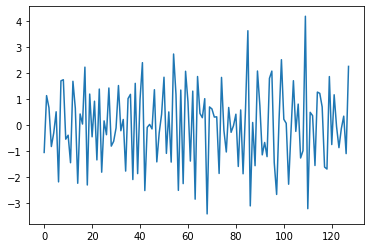

In [745]:
plt.plot(data)
plt.show()

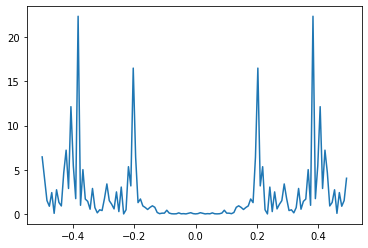

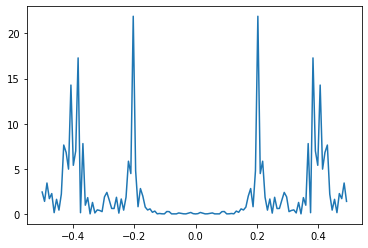

In [746]:
t = np.arange(-N/2, N/2)/N
q = fftshift(periodogram(data))
plt.plot(t,q)
plt.show()

m = fftshift(direct(data, p = 0.5))
plt.plot(t,m)
plt.show()

### (b)

In [747]:
def YW(X, p):
    N = len(X)

    s_tau =[]
    for i in range(p+1):
        sth = 0
        for t in range(N-p):
            sth = sth + X[t]*X[t+i]
        s_tau.append(sth/N)
    Gamma = toeplitz(s_tau[0:p])
    phis = np.linalg.inv(Gamma)@s_tau[1:]

    sum = 0
    for j in range(p):
        sum = sum + phis[j]*s_tau[j]
    sigma = s_tau[0] - sum


    return phis, sigma

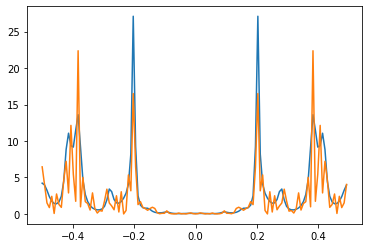

In [748]:

t = np.arange(-N/2, N/2)/N
q = fftshift(periodogram(data))
f = np.linspace(-1/2, 1/2, 1000)
plt.plot(t, S_ARMA(t, YW(data, 20)[0], [], 1))


plt.plot(t,q)
plt.show()

In [749]:
def YW_tapered(X,p, q):
    N = len(X)

    n = np.arange(0,N)
    n1 = n[0:int(np.floor(q*(N))/2)]
    n2 = n[int(np.floor(q*(N))/2): N - int(np.floor(q*N)/2)]
    n3 = n[N - int(np.floor(q*N)/2): ]

    w1 = 0.5*(1- np.cos(2*np.pi*(n1+1)/(np.floor(q*N)+1)))
    w2 = np.ones(n2.shape)
    w3 = 0.5*(1 - np.cos(2*np.pi*(N - n3)/(np.floor(q*N)+1)))
    w = np.concatenate((w1, w2, w3))
    w = w/np.sqrt(sum(w**2))



    s_tau =[]
    for i in range(p+1):
        sth = 0
        for t in range(N-p):
            sth = sth + w[t]*X[t]*X[t+i]*w[t+i]
        s_tau.append(sth/N)
    Gamma = toeplitz(s_tau[0:p])
    phis = np.linalg.inv(Gamma)@s_tau[1:]
    
    sum2 = 0
    for j in range(1,p):
        sum2 = sum2 + phis[j+1]*s_tau[j+1]
    sigma = s_tau[0] - sum2


    return phis, sigma

In [750]:

t = np.arange(-N/2, N/2)/N
q = fftshift(periodogram(data))
f = np.linspace(-1/2, 1/2, 1000)
plt.plot(t, S_ARMA(t, YW_tapered(data, 20, 0.5), [], 1))


plt.plot(t,q)
plt.show()

IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:
def max_likelihood(X,p):
    N = len(X)
    print(N)
    X = X[p:]
    F = 1
    phis = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@X
    return phis

In [ ]:
np.arange(1,21)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

### (c)

In [ ]:
def AIC(p, N, sigma):
    return 2*p + N*np.log(sigma)

for p in np.arange(1,21):
    sigma = YW(data, p)[1]
    print(f"p = {p}: ", AIC(p,len(data),sigma))

p = 1:  146.2155620212209
p = 2:  147.0039994296069
p = 3:  148.84243624951716
p = 4:  150.82085533742506
p = 5:  152.60962443737822
p = 6:  154.62534135672158
p = 7:  156.1550765338564
p = 8:  157.67620955242842
p = 9:  158.0438845840062
p = 10:  157.99576371928245
p = 11:  160.03822471919506
p = 12:  161.48682444348867
p = 13:  163.26737927334747
p = 14:  165.2464678773778
p = 15:  165.72085614189615
p = 16:  167.47991639861434
p = 17:  169.45818654375316
p = 18:  167.2176761899207
p = 19:  157.50848675115589
p = 20:  157.46990479943955


In [ ]:
for p in np.arange(1,21):
    sigma = YW_tapered(data, p, 0.5)[1]
    print(f"p = {p}: ", AIC(p,len(data),sigma))

p = 1:  -510.1634279991097


IndexError: index 2 is out of bounds for axis 0 with size 2